The purpose of this notebook is to:

1. Localize all the necessary data to run DSWx-SAR
2. Create a `yaml` file (proverbially called a RunConfig) for DSWx-SAR
3. Run DSWx-SAR

Most of the code is focused on 1. There are some small todos:

+ Provide an option to serialize data (since re-localizing data takes time and all we need is path)
+ Possibly replace SLC_ID look up in HySDS PST DB with a look up in a table so users don't have to be on PST.

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import asf_search as asf
import geopandas as gpd
import pandas as pd
import rasterio
from shapely.geometry import shape
from rasterio.crs import CRS
from pathlib import Path
from dem_stitcher import stitch_dem
from hand import compute_hand
from tile_stitcher import get_raster_from_tiles
from es_db import get_search_client, get_rtc_urls, download_rtc_products
from dataclasses import dataclass
import yaml
from dswx_sar.dswx_runconfig import RunConfig
import requests

In [3]:
slc_id = 'S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A'

# Parameters

In [4]:
SLC_ID = 'S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A'

# Out Directory

In [5]:
out_directory = Path('out') / SLC_ID
out_directory.mkdir(exist_ok=True, parents=True)

## Get SLC Metadata

In [6]:
opts = asf.ASFSearchOptions(processingLevel=[asf.PRODUCT_TYPE.SLC],
                            beamMode=[asf.BEAMMODE.IW],
                            platform=[asf.PLATFORM.SENTINEL1]
                            )

resp = asf.granule_search([SLC_ID], opts=opts)
geometry = [shape(r.geojson()['geometry']) for r in resp]
df_slc = gpd.GeoDataFrame(geometry=geometry, crs=CRS.from_epsg(4326))
df_slc.head()

,geometry
0,"POLYGON ((-99.04952 37.27494, -98.77662 36.144..."


<Axes: >

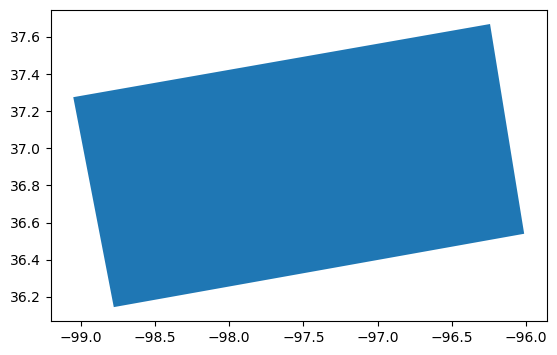

In [7]:
df_slc.plot()

# Auxiliary Datasets

## DEM

In [8]:
bounds = list(df_slc.total_bounds)
bounds

[-99.049522, 36.144268, -96.012474, 37.669025]

In [9]:
dst_area_or_point = 'Point'
dem, p_dem = stitch_dem(bounds, 
                  'glo_30', 
                  dst_area_or_point=dst_area_or_point, 
                  dst_ellipsoidal_height=False)

Reading glo_30 Datasets: 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


In [10]:
dem_path = out_directory / 'glo30_dem.tif'

In [11]:
with rasterio.open(dem_path, 'w', **p_dem) as ds:
   ds.write(dem, 1)
   ds.update_tags(AREA_OR_POINT='Point')

## HAND

In [12]:
%%time

hand = compute_hand(dem_path)

CPU times: user 36.1 s, sys: 3.46 s, total: 39.6 s
Wall time: 33.5 s


In [13]:
hand_path = out_directory / f'hand.tif'

In [14]:
with rasterio.open(hand_path, 'w', **p_dem) as ds:
    ds.write(hand, 1)

## Pekel

In [15]:
X_occ, p_occ = get_raster_from_tiles(bounds, tile_shortname='peckel_water_occ_2021')

In [16]:
occ_path = out_directory / 'pekel_occ.tif'

In [17]:
with rasterio.open(occ_path, 'w', **p_occ) as ds:
    ds.write(X_occ)

## World Cover

In [18]:
X_esa_wc, p_wc = get_raster_from_tiles(bounds, tile_shortname='esa_world_cover_2021')

In [19]:
wc_path = out_directory / f'wc.tif'

In [20]:
with rasterio.open(wc_path, 'w', **p_wc) as ds:
    ds.write(X_esa_wc)

In [21]:
X_esa_wc.shape

(1, 18298, 36446)

# Delete Above Rasters in Memory

In [22]:
del X_esa_wc
del dem
del hand
del X_occ

# Download RTC Data

Requires access to ES database and the `.env` file with JPL credentials.

In [23]:
rtc_product_directory = out_directory / 'rtc_products'
rtc_product_directory.mkdir(exist_ok=True, parents=True)

In [24]:
url_dict = get_rtc_urls(SLC_ID)

36 RTC Products found for S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A


In [25]:
out_paths = download_rtc_products(url_dict, rtc_product_directory)

100%|███████████████████████████████| 216/216 [01:12<00:00,  2.97it/s]


# Generate Yaml/Runconfig

There are three general steps:

1. Get the defaults/templates for parameters and runconfig.
2. Populate the yml with our data (specifically paths and directories)
3. Load the yml as a Runconfig object for the workflow.

The way we figured this out was to keep going through the 3 steps and try running the RunConfig initialization `RunConfig.load_from_yaml`. Usually the loading tells the user what needs filling out on account of yaml validation. It's not pretty.

In [26]:
dswx_sar_pge_url = 'https://raw.githubusercontent.com/opera-adt/DSWX-SAR/main/src/dswx_sar/defaults/dswx_s1.yaml'
dswx_sar_param_url = 'https://raw.githubusercontent.com/opera-adt/DSWX-SAR/main/src/dswx_sar/defaults/algorithm_parameter_s1.yaml'

## Load default ymls from upstream repository

In [29]:
resp = requests.get(dswx_sar_pge_url)
resp_param = requests.get(dswx_sar_param_url)

In [30]:
param_dict = yaml.safe_load(resp_param.content)
param_dict

{'runconfig': {'name': 'dswx_s1_workflow_algorithm',
  'processing': {'dswx_workflow': 'opera_dswx_s1',
   'polarizations': ['VV', 'VH'],
   'reference_water': {'max_value': 100,
    'no_data_value': 255,
    'permanent_water_value': 0.9,
    'drought_erosion_pixel': 10,
    'flood_dilation_pixel': 16},
   'hand': {'mask_value': 200},
   'mosaic': {'mosaic_prefix': 'mosaic', 'mosaic_cog_enable': True},
   'filter': {'enabled': True, 'window_size': 5},
   'initial_threshold': {'maximum_tile_size': {'x': 400, 'y': 400},
    'minimum_tile_size': {'x': 40, 'y': 40},
    'selection_method': 'combined',
    'tile_selection_twele': [0.09, 0.8, 0.97],
    'tile_selection_bimodality': 0.7,
    'extending_method': 'gdal_grid',
    'threshold_method': 'ki',
    'multi_threshold': True,
    'number_cpu': -1,
    'number_iterations': 1,
    'tile_average': False},
   'fuzzy_value': {'line_per_block': 200,
    'hand': {'member_min': 0, 'member_max': 15},
    'slope': {'member_min': 0.5, 'member_max'

In [31]:
input_dict = yaml.safe_load(resp.content)
input_dict

{'runconfig': {'name': 'dswx_s1_workflow_default',
  'groups': {'pge_name_group': {'pge_name': 'DSWX_S1_PGE'},
   'input_file_group': {'input_file_path': None},
   'dynamic_ancillary_file_group': {'dem_file': None,
    'dem_file_description': None,
    'worldcover_file': None,
    'worldcover_file_description': None,
    'reference_water_file': None,
    'reference_water_file_description': None,
    'hand_file': None,
    'hand_file_description': None,
    'shoreline_shapefile': None,
    'shoreline_shapefile_description': None,
    'algorithm_parameters': None},
   'static_ancillary_file_group': {'static_ancillary_inputs_flag': True,
    'mgrs_database_file': None,
    'mgrs_collection_database_file': None},
   'primary_executable': {'product_type': 'DSWX_S1'},
   'product_path_group': {'product_path': None,
    'scratch_path': None,
    'sas_output_path': None,
    'product_version': None,
    'output_imagery_format': 'COG',
    'output_imagery_compression': 'DEFLATE',
    'output_im

## Injecting parameters in relevant yml

In [32]:
rtc_paths = list(rtc_product_directory.glob('*/'))
rtc_paths_str = list(map(str, rtc_paths))
rtc_paths_str = list(map(lambda s: s + '/', rtc_paths_str))
rtc_paths_str[:3]

['out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/rtc_products/OPERA_L2_RTC-S1_T034-071095-IW3_20211212T002820Z_20230929T210202Z_S1B_30_v1.0/',
 'out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/rtc_products/OPERA_L2_RTC-S1_T034-071100-IW2_20211212T002832Z_20230929T210202Z_S1B_30_v1.0/',
 'out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/rtc_products/OPERA_L2_RTC-S1_T034-071099-IW2_20211212T002830Z_20230929T210202Z_S1B_30_v1.0/']

In [33]:
scratch_dir = (out_directory / 'scratch').resolve()
sas_dir = (out_directory / 'sas').resolve()
product_dir = (out_directory / 'product_path').resolve()
[d.mkdir(exist_ok=True, parents=True) for d in [scratch_dir, sas_dir, product_dir]]

[None, None, None]

In [34]:
input_dict['runconfig']['groups']['input_file_group']['input_file_path'] = rtc_paths_str
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file']= str(dem_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['worldcover_file']= str(wc_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['hand_file']= str(hand_path.resolve())
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['reference_water_file']= str(occ_path.resolve())
input_dict['runconfig']['groups']['product_path_group']['scratch_path'] = str(scratch_dir)
input_dict['runconfig']['groups']['product_path_group']['sas_output_path'] = str(sas_dir)
input_dict['runconfig']['groups']['product_path_group']['product_path'] = str(product_dir)

input_dict['runconfig']['groups']['primary_executable']['product_type'] = 'dswx_s1'
input_dict['runconfig']['groups']['static_ancillary_file_group']['static_ancillary_inputs_flag'] = False

Make sure empty string rather than `None` is populated in yml.

In [35]:
# See: https://stackoverflow.com/a/41786451
def represent_none(self, _):
    return self.represent_scalar('tag:yaml.org,2002:null', '')

yaml.add_representer(type(None), represent_none)

In [36]:
params_path = out_directory / 'params.yml'
with open(params_path, 'w') as param_file:
    yaml.dump(param_dict, param_file)

In [37]:
input_dict['runconfig']['groups']['dynamic_ancillary_file_group']['algorithm_parameters'] = str(params_path.resolve())

In [38]:
log_path = str(out_directory/f'{SLC_ID}.log')

@dataclass
class Args:
    """placeholder"""
    debug_mode = False
    log_file = log_path

In [39]:
args = Args()

In [40]:
run_config_path = out_directory / 'run_config.yml'
with open(run_config_path, 'w') as run_config_yaml:
    yaml.dump(input_dict, run_config_yaml)

In [41]:
cfg = RunConfig.load_from_yaml(str(run_config_path), 'dswx_s1', args)

command line log file "out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A.log" has precedence over runconfig log file "None"


# Run Workflow

In [42]:
from dswx_sar.dswx_s1 import dswx_s1_workflow

dswx_s1_workflow(cfg)

Number of bursts to process: 36
    mosaic geogrid:
        start X: 492570.0
        end X: 769710.0
        start Y: 4179120.0
        end Y: 3994740.0
        spacing X: 30.0
        spacing Y: -30.0
        width: 9238
        length: 6146
        projection: PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32614"]]
        number of bands: 1
    mosaicking (1/36): OPERA_L2_RTC-S1_T034-071095-IW3_20211212T002820Z_20230929T210202Z_S1B_30_v1.0_VV.tif
  

/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be e

Grid data type is "Float64"
Grid size = (9238 6146).
Corner coordinates = (0.000000 6146.000000)-(9238.000000 0.000000).
Grid cell size = (1.000000 -1.000000).
Source point count = 550.
Algorithm name: "invdist".
Options are "power=0.500000:smoothing=1.000000:radius1=800.000000:radius2=800.000000:angle=0.000000:max_points=0:min_points=1:nodata=0.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/int_threshold_filled_VV.tif ... (6146, 9238)


Warning 1: libXML: 0: Element 'GeometryField', attribute 'separator': The attribute 'separator' is not allowed.


Grid data type is "Float64"
Grid size = (9238 6146).
Corner coordinates = (0.000000 6146.000000)-(9238.000000 0.000000).
Grid cell size = (1.000000 -1.000000).
Source point count = 583.
Algorithm name: "invdist".
Options are "power=0.500000:smoothing=1.000000:radius1=800.000000:radius2=800.000000:angle=0.000000:max_points=0:min_points=1:nodata=0.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/int_threshold_filled_VH.tif ... (6146, 9238)


Warning 1: libXML: 0: Element 'GeometryField', attribute 'separator': The attribute 'separator' is not allowed.


Grid data type is "Float64"
Grid size = (9238 6146).
Corner coordinates = (0.000000 6146.000000)-(9238.000000 0.000000).
Grid cell size = (1.000000 -1.000000).
Source point count = 550.
Algorithm name: "invdist".
Options are "power=0.500000:smoothing=1.000000:radius1=800.000000:radius2=800.000000:angle=0.000000:max_points=0:min_points=1:nodata=0.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/mode_tau_filled_VV.tif ... (6146, 9238)


Warning 1: libXML: 0: Element 'GeometryField', attribute 'separator': The attribute 'separator' is not allowed.


Grid data type is "Float64"
Grid size = (9238 6146).
Corner coordinates = (0.000000 6146.000000)-(9238.000000 0.000000).
Grid cell size = (1.000000 -1.000000).
Source point count = 583.
Algorithm name: "invdist".
Options are "power=0.500000:smoothing=1.000000:radius1=800.000000:radius2=800.000000:angle=0.000000:max_points=0:min_points=1:nodata=0.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/mode_tau_filled_VH.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/interpolated_DEM ... (6146, 9238)
100 - done.
0...10...20...30...40...50...60...70...80...90...

/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/dswx_sar/fuzzy_value_computation.py:485: RuntimeWarning: Mean of empty slice
  mean_intensity = np.nanmean(intensity, axis=0)
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/fuzzy_image_VV_VH.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/temp_region_growing_VV_VH.tif ... (6146, 9238)
Saving dswx product : /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/region_growing_output_binary_VV_VH.tif 
100 - done.
0...10...20...30...40...50...60...70...80...90... -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/region_growing_output_binary_VV_VH.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/filtered_image_VV_VH.tif ... (2,

/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cmarshak/mambaforge/envs/dswx_val/l

 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/interpolated_landcover ... (6146, 9238)
Saving dswx product : /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/refine_landcover_binary_VV_VH.tif 
    no_data found 120
100 - done.
0...10...20...30...40...50...60...70...80...90... -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/filtered_image_VV_VH.tif ... (2, 6146, 9238)
Saving dswx product : /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/no_data_area_VV_VH.tif 
100 - done.
0...10...20...30...40...50...60...70...80...90... -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_0299

/Users/cmarshak/mambaforge/envs/dswx_val/lib/python3.11/site-packages/dswx_sar/refine_with_bimodality.py:150: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-(array - mu)**2 / 2 / sigma ** 2)


 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/no_data_area_VV_VH.tif ... (6146, 9238)
100 - done.
0...10...20...30...40...50...60...70...80...90...Saving dswx product : /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/bimodality_output_binary_VV_VH.tif 
100 - done.
0...10...20...30...40...50...60...70...80...90...>> lee_enhanced_filter
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/interpolated_landcover ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/interpolated_landcover ... (6146, 9238)
/Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A

 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/bimodality_output_binary_VV_VH.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/no_data_area_VV_VH.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/mosaic_layovershadow_mask.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/interpolated_hand ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/out/S1B_IW_SLC__1SDV_20211212T002818_20211212T002836_029985_03946A_6D2A/scratch/temp_inundated_vegetation.tif ... (6146, 9238)
 -- Reading /Users/cmarshak/bekaert-team/dswx-sar-workflow-pst/o